In [1]:
from pathlib import Path
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

PROJECT = Path(r"C:\Users\ashak\ad-quantum-repurpose")
LIG_PROC = PROJECT / "data" / "processed" / "ligands"
DOCK_CSV = PROJECT / "results" / "docking" / "docking_results.csv"
assert DOCK_CSV.exists()

df = pd.read_csv(DOCK_CSV)

# compute descriptors (MW, PSA, cLogP) from the SDFs we created earlier
def get_desc(name):
    sdf = LIG_PROC / f"{name}.sdf"
    mols = list(Chem.SDMolSupplier(str(sdf), removeHs=False))
    mol = mols[0] if mols else None
    if mol is None:
        return pd.Series(dict(MW=None, PSA=None, cLogP=None))
    mw = rdMolDescriptors.CalcExactMolWt(mol)
    psa = rdMolDescriptors.CalcTPSA(mol)
    clogp = rdMolDescriptors.CalcCrippenDescriptors(mol)[0]
    return pd.Series(dict(MW=mw, PSA=psa, cLogP=clogp))

desc = df["ligand"].apply(get_desc)
df = pd.concat([df, desc], axis=1)

# simple CNS filters (not strict, just indicative)
df["BBB_pass"] = (df["cLogP"].between(2.0, 5.0, inclusive="both")) & (df["PSA"] < 90.0)
df.sort_values("affinity_kcal_mol", inplace=True)  # more negative = better

df.head(10)


,ligand,pose_path,log_path,retcode,affinity_kcal_mol,parsed_from,MW,PSA,cLogP,BBB_pass
0,donepezil,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-8.2,log_table,392.209993,42.01,3.85640,True
1,galantamine,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-7.6,log_table,278.094294,39.44,4.24490,True
2,nilvadipine,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-7.0,log_table,433.048378,78.51,4.46442,True
3,fluoxetine,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-6.7,log_table,259.137242,35.25,3.79590,True
4,sertraline,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-6.6,log_table,283.089455,12.03,4.46690,True
5,riluzole,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-6.4,log_table,253.018894,76.72,2.13950,True
6,rivastigmine,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-6.1,log_table,221.105193,38.77,2.03590,True
7,memantine,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-5.9,log_table,181.183050,26.02,3.08420,True
8,rasagiline,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-5.7,log_table,191.111028,12.03,2.17520,True
9,selegiline,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-5.4,log_table,173.120449,12.03,2.03610,True


In [2]:
import numpy as np

# normalize docking: more negative is better -> invert sign first
dock = -df["affinity_kcal_mol"]
dock_z = (dock - dock.mean()) / (dock.std(ddof=0) if dock.std(ddof=0)!=0 else 1.0)

# small bonus for BBB_pass
bbb_bonus = df["BBB_pass"].astype(int) * 0.25

df["composite_score"] = dock_z + bbb_bonus
df_ranked = df.sort_values("composite_score", ascending=False).reset_index(drop=True)
df_ranked[["ligand","affinity_kcal_mol","MW","PSA","cLogP","BBB_pass","composite_score"]]


,ligand,affinity_kcal_mol,MW,PSA,cLogP,BBB_pass,composite_score
0,donepezil,-8.2,392.209993,42.01,3.85640,True,2.247032
1,galantamine,-7.6,278.094294,39.44,4.24490,True,1.516411
2,nilvadipine,-7.0,433.048378,78.51,4.46442,True,0.785789
3,fluoxetine,-6.7,259.137242,35.25,3.79590,True,0.420478
4,sertraline,-6.6,283.089455,12.03,4.46690,True,0.298708
5,riluzole,-6.4,253.018894,76.72,2.13950,True,0.055168
6,rivastigmine,-6.1,221.105193,38.77,2.03590,True,-0.310143
7,memantine,-5.9,181.183050,26.02,3.08420,True,-0.553684
8,rasagiline,-5.7,191.111028,12.03,2.17520,True,-0.797224
9,selegiline,-5.4,173.120449,12.03,2.03610,True,-1.162535


WindowsPath('C:/Users/ashak/ad-quantum-repurpose/results/reports/docking_bar.png')

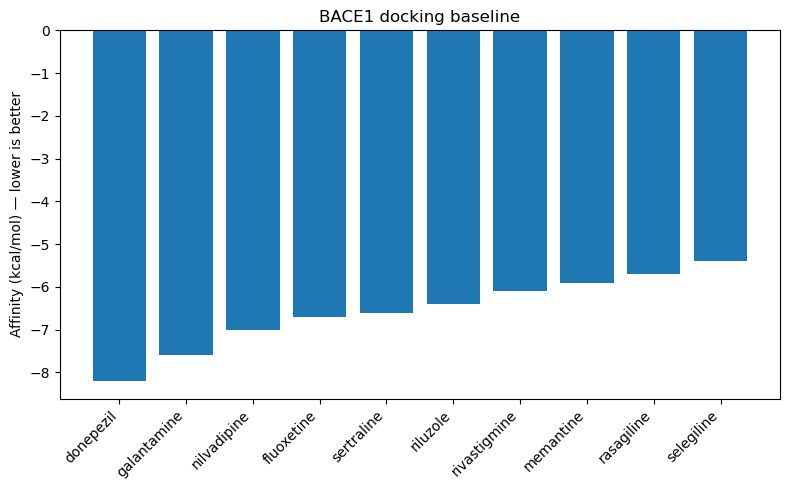

In [3]:
import matplotlib.pyplot as plt

xs = df_ranked["ligand"]
ys = df_ranked["affinity_kcal_mol"]

plt.figure(figsize=(8,5))
plt.bar(xs, ys)  # do not set colors per our plotting rule
plt.xticks(rotation=45, ha="right")
plt.ylabel("Affinity (kcal/mol) — lower is better")
plt.title("BACE1 docking baseline")
plt.tight_layout()
plot_path = PROJECT / "results" / "reports" / "docking_bar.png"
plot_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(plot_path, dpi=150)
plot_path


In [6]:
report_md = PROJECT / "results" / "reports" / "ranking.md"
top5 = df_ranked.head(5)[["ligand","affinity_kcal_mol","BBB_pass","composite_score"]]

lines = ["# Docking Baseline (BACE1, 4DVF)\n",
         "- Grid center: [3.061, -0.128, 17.532]\n",
         f"- Candidates docked: {len(df_ranked)}\n",
         "\n## Top 5 by composite score\n",
         top5.to_markdown(index=False),
         "\n\n![Docking bar](docking_bar.png)\n"]
report_md.write_text("\n".join(lines), encoding="utf-8")

csv_rank = PROJECT / "results" / "reports" / "ranking_table.csv"
df_ranked.to_csv(csv_rank, index=False)
report_md, csv_rank


(WindowsPath('C:/Users/ashak/ad-quantum-repurpose/results/reports/ranking.md'),
 WindowsPath('C:/Users/ashak/ad-quantum-repurpose/results/reports/ranking_table.csv'))